### **Handling Overfitting in Deep Learning: Dropout Regularization Technique**

* Overfitting is a common and critical problem in machine learning, particularly in deep learning models. 

* It occurs when a model learns the training data *too well*, including the noise and random fluctuations, to the detriment of its ability to generalize to new, unseen data.

Imagine you are teaching a student for a test.

  * **A well-generalized student** understands the core concepts. They can answer questions they haven't seen before because they have a deep understanding of the subject matter.

  * **An overfit student** has only memorized the answers to the specific practice questions. When they encounter a new question on the actual test, they fail because they lack a true understanding of the underlying principles.

In a neural network, overfitting manifests as:

  * **High training accuracy:** The model performs exceptionally well on the data it was trained on.

  * **Low validation/test accuracy:** The model performs poorly on new data.

This indicates that the model has essentially "memorized" the training examples rather than learning the general patterns.

#### How to detect overfitting?

* We typically monitor the model's performance on both the training data and a separate validation dataset during the training process.

* If the training loss continues to decrease, but the validation loss starts to increase, it is a clear sign that the model is overfitting.

#### Why does it happen?

Overfitting is more likely to occur in:

  * **Complex models:** Models with many layers or a large number of parameters have the capacity to memorize the training data.

  * **Small datasets:** If the training data is not representative or is too small, the model may fail to learn generalizable patterns.

* **Regularization** techniques are methods used to prevent overfitting and improve the generalization of a model. 

* **Dropout** is one of the most effective and widely used regularization techniques for deep learning.

#### **Dropout Regularization**

* Dropout is a simple yet powerful regularization technique. 

* The core idea is to randomly "drop" (i.e., set to zero) a certain percentage of neurons in a layer during each training iteration.

##### How does it work?

  1.  **During training:** For each training example and each training step, a dropout layer randomly selects a fraction of the neurons and temporarily removes them from the network.

  2.  **A different "thinned" network:** This process creates a different, smaller network for each training batch. A dropout rate of 0.5 (or 50%) means that, on average, half of the neurons in that layer will be dropped.

  3.  **Prevents co-adaptation:** This random dropping of neurons prevents them from "co-adapting" with each other. Neurons cannot rely on the output of specific other neurons, forcing them to learn more robust and general features. This is analogous to a team where members are randomly absent, forcing the remaining members to become more adaptable and well-rounded.

  4.  **During inference (testing):** Dropout is *turned off*. All neurons are used, but their outputs are scaled down by the dropout rate. For example, if the dropout rate was 0.5, the output of each neuron would be multiplied by 0.5. This ensures that the expected total output of the layer remains the same as during training, leading to more consistent predictions.


---

* This notebook provides a step-by-step guide to understanding and implementing Dropout Regularization in a deep learning model. 

* We will use the "Connectionist Bench (Sonar, Mines vs. Rocks)" dataset to demonstrate how Dropout helps to combat overfitting and improve model generalization.

#### Step 1: Library Imports and Data Loading

* We begin by importing the necessary libraries for data manipulation, deep learning model building, and visualization. 

* We will then load the dataset directly from the UCI Machine Learning Repository.

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
from tensorflow import keras

In [3]:
# Load the dataset
data_url = "http://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data"
df = pd.read_csv(data_url, header=None)

print("Dataset loaded successfully. Shape:", df.shape)

Dataset loaded successfully. Shape: (208, 61)


In [4]:
print("\nFirst 5 rows of the dataset:")
df.head()


First 5 rows of the dataset:


,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


In [7]:
# Display column names
df.columns

Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60],
      dtype='int64')

In [9]:
 # Display value counts for each class
df[60].value_counts()

60
M    111
R     97
Name: count, dtype: int64

#### Step 2: Data Preprocessing

* The dataset contains 60 numerical features and a single categorical target variable (`'M'` for Mine, `'R'` for Rock). 

* We need to perform the following preprocessing steps:
  
  1.  **Separate features and target:** Split the DataFrame into `X` (features) and `y` (target).

  2.  **Label Encoding:** Convert the categorical target `'R'` and `'M'` into numerical values (`0` and `1`).

  3.  **Normalization/Standardization:** Scale the numerical features. This is crucial for neural networks to ensure stable and faster convergence.

  4.  **Train-Test Split:** Partition the data into training and testing sets to evaluate the model's performance on unseen data.

In [243]:
# Separate features (X) and target (y)
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Label Encoding for the target variable
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Standardization of features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (145, 60)
Shape of y_train: (145,)
Shape of X_test: (63, 60)
Shape of y_test: (63,)


#### Step 3: Building a Baseline Model (Without Dropout)

* First, we'll build a standard deep neural network to serve as our baseline. 

* This model will likely overfit, especially given the relatively small dataset size, which will highlight the importance of regularization.

In [244]:
# Define the baseline model
baseline_model = keras.Sequential([
    keras.layers.Input(shape=(X_train.shape[1],)),
    keras.layers.Dense(60, activation='relu'),
    keras.layers.Dense(30, activation='relu'),
    keras.layers.Dense(15, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

baseline_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print("Baseline Model Summary:")
baseline_model.summary()

Baseline Model Summary:


Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_141 (Dense)               │ (None, 60)             │         3,660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_142 (Dense)               │ (None, 30)             │         1,830 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_143 (Dense)               │ (None, 15)             │           465 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_144 (Dense)               │ (None, 1)              │            16 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,971 (23.32 KB)

 Trainable params: 5,971 (23.32 KB)

 Non-trainable params: 0 (0.00 B)

#### Step 4: Training the Baseline Model and Visualizing Overfitting

* We will train the baseline model and plot its training and validation loss/accuracy. 

* A clear divergence between the two curves is a hallmark of overfitting.

In [245]:
# Train the baseline model
baseline_history = baseline_model.fit(X_train, y_train, epochs=100, batch_size=8, validation_data=(X_test, y_test))

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5103 - loss: 0.7757 - val_accuracy: 0.5079 - val_loss: 0.6968
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6552 - loss: 0.5862 - val_accuracy: 0.6032 - val_loss: 0.6328
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7517 - loss: 0.4989 - val_accuracy: 0.6508 - val_loss: 0.5868
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8000 - loss: 0.4352 - val_accuracy: 0.7143 - val_loss: 0.5425
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8966 - loss: 0.3643 - val_accuracy: 0.7460 - val_loss: 0.4954
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9310 - loss: 0.3015 - val_accuracy: 0.8095 - val_loss: 0.4399
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9655 - loss: 0.2388 - val_accuracy: 0.8095 - val_loss: 0.4004
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9862 - loss: 0.1866 - val_accuracy: 0.

#### Step 4: Training the Baseline Model and Visualizing Overfitting

* We will train the baseline model and plot its training and validation loss/accuracy. 

* A clear divergence between the two curves is a hallmark of overfitting.

In [246]:
# Evaluate the baseline model
print("Evaluating the baseline model on test data:")
baseline_model.evaluate(X_test, y_test)

Evaluating the baseline model on test data:
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7619 - loss: 0.8840


[0.8839990496635437, 0.761904776096344]

**Training Accuracy >>> Testing Accuracy**

In [247]:
# Classification Report and Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix 

y_pred = (baseline_model.predict(X_test) > 0.5).astype("int32")
print("Classification Report:\n", classification_report(y_test, y_pred))


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 269ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.79      0.78        34
           1       0.75      0.72      0.74        29

    accuracy                           0.76        63
   macro avg       0.76      0.76      0.76        63
weighted avg       0.76      0.76      0.76        63



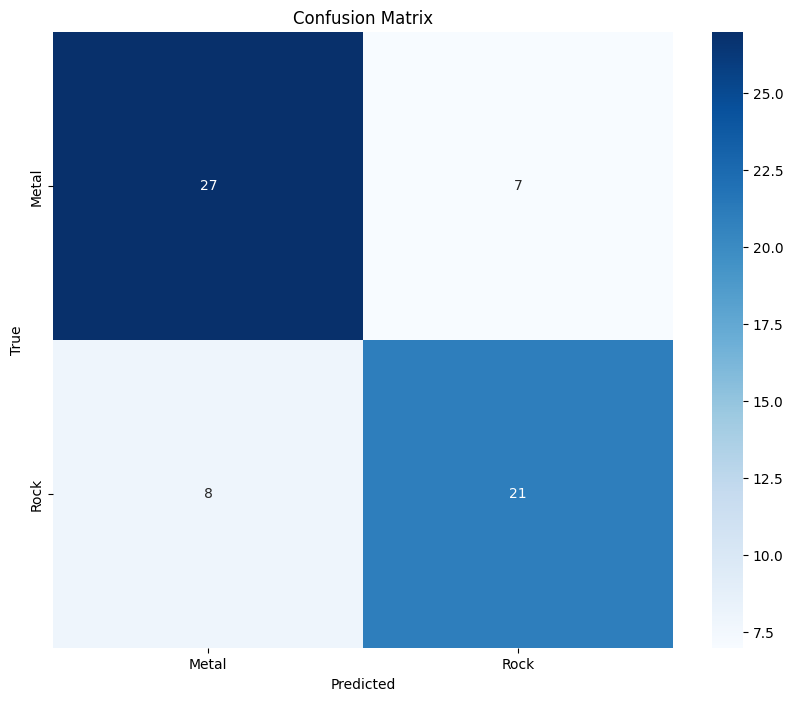

In [248]:
# Confusion Matrix of the Baseline Model
cm = confusion_matrix(y_test, y_pred)

import seaborn as sns
# Plotting the Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Metal", "Rock"], yticklabels=["Metal", "Rock"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

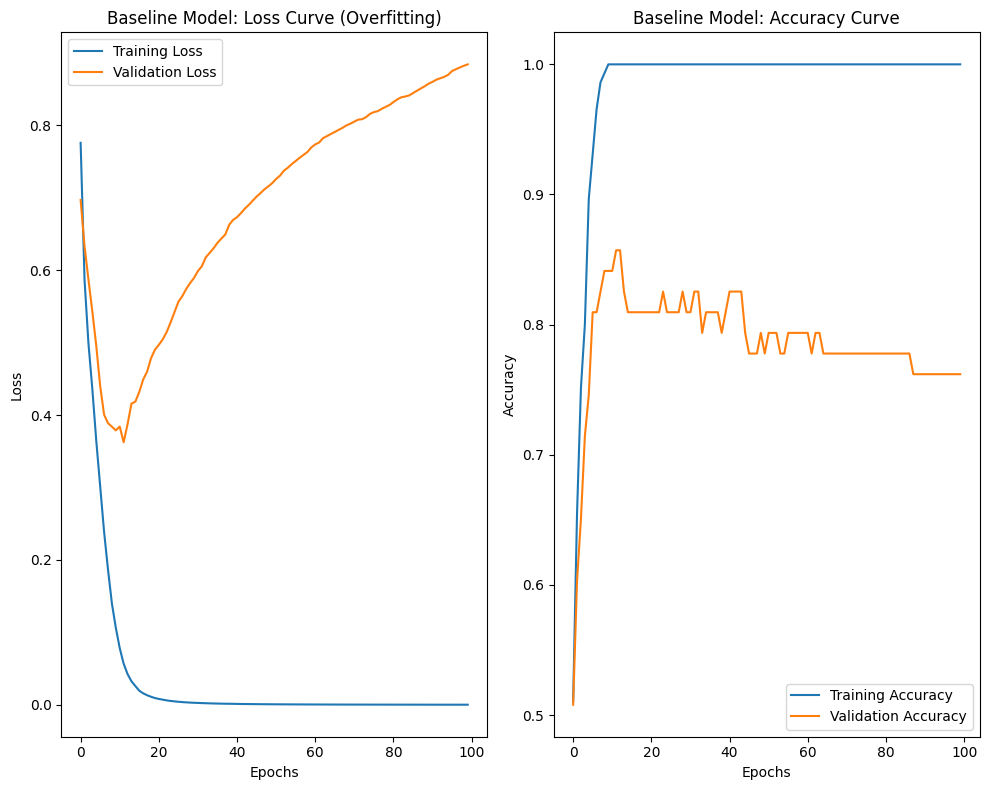

Final Baseline Model Accuracy: 76.19%


In [249]:
# Plot training and validation loss
plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.plot(baseline_history.history['loss'], label='Training Loss')
plt.plot(baseline_history.history['val_loss'], label='Validation Loss')
plt.title('Baseline Model: Loss Curve (Overfitting)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(baseline_history.history['accuracy'], label='Training Accuracy')
plt.plot(baseline_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Baseline Model: Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

_, baseline_acc = baseline_model.evaluate(X_test, y_test, verbose=0)
print(f"Final Baseline Model Accuracy: {baseline_acc*100:.2f}%")

**Observation:** The training loss decreases consistently, but the validation loss starts to flatten out or even increase after a few epochs. This confirms that the model is overfitting the training data.

#### Step 5: Building a Model with Dropout Regularization

* Now, let's create a new model with the same architecture but add `Dropout` layers after the `Dense` layers. 

* We'll use a dropout rate of 0.5, which is a common starting point. 

* The `Dropout` layer randomly sets a fraction of input units to 0 at each update during training, which helps prevent overfitting.

In [250]:
# Define the model with Dropout layers
dropout_model = keras.Sequential([
    keras.layers.Input(shape=(X_train.shape[1],)),
    keras.layers.Dense(60, activation='relu'),
    keras.layers.Dropout(0.2), # Add Dropout layer
    keras.layers.Dense(30, activation='relu'),
    keras.layers.Dropout(0.2), # Add Dropout layer
    keras.layers.Dense(15, activation='relu'),
    keras.layers.Dropout(0.2), # Add Dropout layer
    keras.layers.Dense(1, activation='sigmoid')
])

dropout_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print("Model with Dropout Summary:")
dropout_model.summary()

Model with Dropout Summary:


Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_145 (Dense)               │ (None, 60)             │         3,660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_146 (Dense)               │ (None, 30)             │         1,830 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_147 (Dense)               │ (None, 15)             │           465 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_148 (Dense)               │ (None, 1)              │            16 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,971 (23.32 KB)

 Trainable params: 5,971 (23.32 KB)

 Non-trainable params: 0 (0.00 B)

#### Step 6: Training the Dropout Model and Comparison

* We'll train the new model with dropout and then compare its performance curves with the baseline model. 

* We should see a smaller gap between the training and validation curves, indicating better generalization.

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.4897 - loss: 0.7646 - val_accuracy: 0.6667 - val_loss: 0.6589
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6207 - loss: 0.6470 - val_accuracy: 0.7143 - val_loss: 0.6238
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6552 - loss: 0.6018 - val_accuracy: 0.7778 - val_loss: 0.5856
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7241 - loss: 0.5387 - val_accuracy: 0.6667 - val_loss: 0.5584
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7862 - loss: 0.4751 - val_accuracy: 0.6984 - val_loss: 0.5411
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8276 - loss: 0.4207 - val_accuracy: 0.6667 - val_loss: 0.5225
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8207 - loss: 0.4075 - val_accuracy: 0.6984 - val_loss: 0.5060
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8276 - loss: 0.3586 - val_accuracy: 0.

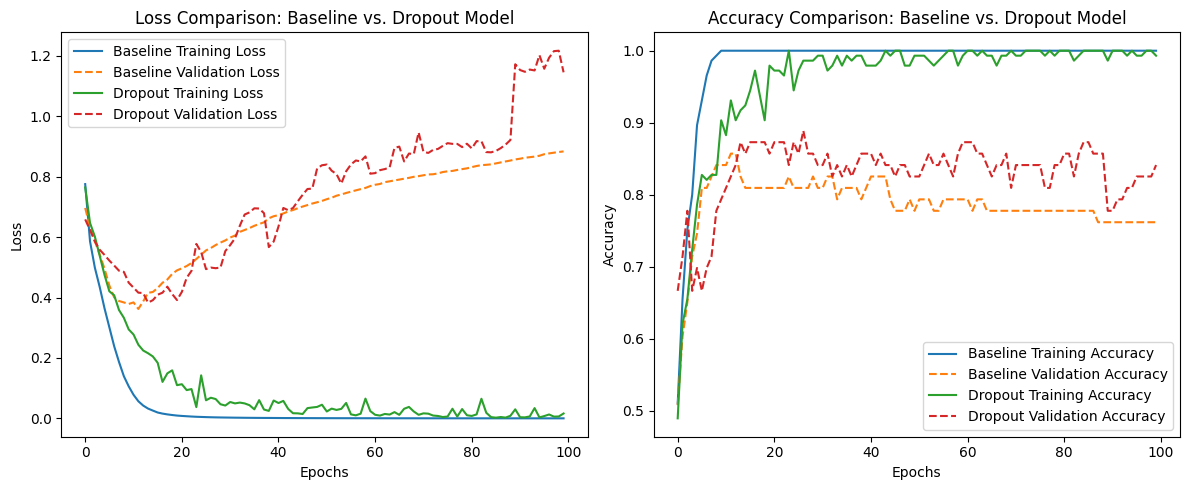

Final Dropout Model Accuracy: 84.13%


In [251]:
# Train the dropout model
dropout_history = dropout_model.fit(X_train, y_train, epochs=100, batch_size=8, validation_data=(X_test, y_test))

# Plot training and validation loss for both models
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(baseline_history.history['loss'], label='Baseline Training Loss')
plt.plot(baseline_history.history['val_loss'], label='Baseline Validation Loss', linestyle='--')
plt.plot(dropout_history.history['loss'], label='Dropout Training Loss')
plt.plot(dropout_history.history['val_loss'], label='Dropout Validation Loss', linestyle='--')
plt.title('Loss Comparison: Baseline vs. Dropout Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy for both models
plt.subplot(1, 2, 2)
plt.plot(baseline_history.history['accuracy'], label='Baseline Training Accuracy')
plt.plot(baseline_history.history['val_accuracy'], label='Baseline Validation Accuracy', linestyle='--')
plt.plot(dropout_history.history['accuracy'], label='Dropout Training Accuracy')
plt.plot(dropout_history.history['val_accuracy'], label='Dropout Validation Accuracy', linestyle='--')
plt.title('Accuracy Comparison: Baseline vs. Dropout Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

_, dropout_acc = dropout_model.evaluate(X_test, y_test, verbose=0)
print(f"Final Dropout Model Accuracy: {dropout_acc*100:.2f}%")

#### **Summary:** 

* The dropout model's validation loss curve is much smoother and remains closer to the training loss curve, and the validation accuracy is generally higher and more stable. 

* This demonstrates that **Dropout regularization successfully reduced overfitting**, leading to a model that generalizes better to unseen data. 

* The final accuracy of the dropout model should be noticeably higher than the baseline model.

---

*Deep Learning - Python Notebook* by [*Prakash Ukhalkar*](https://github.com/prakash-ukhalkar)